In [1]:
import ast
import matplotlib.pyplot as plt
import multiprocess as mp
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import sys
import torch
import time

from collections import deque
from concorde.tsp import TSPSolver
from concorde.tests.data_utils import get_dataset_path
from graph_utils import plot_network
from python_tsp.exact import solve_tsp_dynamic_programming
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
# from torchsummary import summary

from agent import Agent
from env import MVCEnv, TSPEnv
from model import QNetwork
from solver import solve, solve2

%load_ext autoreload
%autoreload 2

/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
list(map(str, range(env.n)))

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14']

In [79]:
for u,v in env.G.edges:
    print(u,v)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 12
0 13
1 5
1 7
1 8
1 9
1 11
1 12
2 5
2 6
2 14
4 5
4 6
4 8
4 10
4 13
4 14
5 6
5 7
5 8
5 9
6 7
6 9
6 10
6 11
7 12
7 14
8 10
8 11
10 11
10 12
10 13
11 13
12 14


In [84]:
!pip install cplex

ERROR: Could not find a version that satisfies the requirement cplex (from versions: none)
ERROR: No matching distribution found for cplex


In [80]:
def get_cplex_solution(env):
    prob = cplex.Cplex()
    prob.set_problem_name("Minimum Vertex Cover")

    # PROBLEM TYPE OPTIONS
    # =============================
    # Cplex.problem_type.LP
    # Cplex.problem_type.MILP
    # Cplex.problem_type.fixed_MILP
    # Cplex.problem_type.QP
    # Cplex.problem_type.MIQP
    # Cplex.problem_type.fixed_MIQP
    # Cplex.problem_type.QCP
    # Cplex.problem_type.MIQCP
    # =============================
    prob.set_problem_type(cplex.Cplex.problem_type.LP)

    # We want to find a maximum of our objective function
    prob.objective.set_sense(prob.objective.sense.minimize)

    # Variable Names
    names = list(map(str, range(env.n)))

    # Objective (linear) weights
    w_obj = np.ones(env.n)
    # Lower bounds. Since these are all zero, we could simply not pass them in as
    # all zeroes is the default.
    low_bnd = np.zeros(env.n)
    # Upper bounds. The default here would be cplex.infinity, or 1e+20.
    upr_bnd = np.ones(env.n)
    prob.variables.add(names=names, obj=w_obj, lb=low_bnd, ub=upr_bnd)

    # How to set the variable types
    # Must be AFTER adding the variablers
    #
    # Option #1: Single variable name (or number) with type
    # prob.variables.set_types("0", prob.variables.type.continuous)
    # Option #2: List of tuples in the form (var_name, type)
    # prob.variables.set_types([("1", prob.variables.type.integer), \
    #                           ("2", prob.variables.type.binary), \
    #                           ("3", prob.variables.type.semi_continuous), \
    #                           ("4", prob.variables.type.semi_integer)])
    #
    # Vertex cover requires only integers
    all_int = [(var, prob.variables.type.integer) for var in names]
    prob.variables.set_types(all_int)

    constraints = []
    for (u, v) in env.G.edges:
        constraints.append([[str(u), str(v)], [1, 1]])

    # Constraint names
    constraint_names = ["".join(x[0]) for x in constraints]

    # Each edge must have at least one vertex
    rhs = [1] * len(constraints)

    # We need to enter the senses of the constraints. That is, we need to tell Cplex
    # whether each constrains should be treated as an upper-limit (≤, denoted "L"
    # for less-than), a lower limit (≥, denoted "G" for greater than) or an equality
    # (=, denoted "E" for equality)
    constraint_senses = ["G"] * len(constraints)

    # And add the constraints
    prob.linear_constraints.add(
        names=constraint_names,
        lin_expr=constraints,
        senses=constraint_senses,
        rhs=rhs
    )
    # Solve the problem
    print("Problem Type: %s" % prob.problem_type[prob.get_problem_type()])
    prob.solve()
    print("Solution result is: %s" % prob.solution.get_status_string())
    solution = prob.solution.get_values()
    print(solution)

    return solution

In [75]:
def get_solution(env, exact_solution_max_size=0, return_path=False):
    if env.G.number_of_nodes() <= exact_solution_max_size:
        raise NotImplemented("Exact solution not implemented yet")
    else:
        return get_cplex_solution(env)

In [2]:
def run_validation(agent, env, n_episodes_validation, exact_solution_max_size=0, print_to_file=sys.stdout):
    agent.qnetwork_target.eval()
    agent.qnetwork_local.eval()
    val_scores = []
    for i in range(1, n_episodes_validation+1):
        score = run_episode(agent, env, train_mode=False)[0] * (env.normalize_reward * env.pos_lim)
        solution = get_solution(env, exact_solution_max_size)
        print(-score, solution, -score/solution)
        approximation_ration = -score/solution
        val_scores.append(approximation_ration)
    
    val_scores = np.array(val_scores)
    val_stats = pd.Series(val_scores).describe()
    print(
        f"[Validation] "
        f"Mean: {val_stats['mean']}, "
        f"Std dev: {val_stats['std']}, "
        f"Optimal: {100 * (abs(val_scores - 1.0) < 1e-6).sum() / n_episodes_validation :.2f}%",
        file=print_to_file
    )
    
    agent.qnetwork_target.train()
    agent.qnetwork_local.train()

    return val_stats

In [3]:
def run_episode(agent, env, eps_start=0, eps_decay=0, eps_end=0, train_mode=True, print_actions=False):
    state = env.reset()
    agent.reset_episode(env.G)
    score = 0
    eps = eps_start
    while True:
        action = agent.act(state, eps=eps if train_mode else 0)
        if print_actions:
            print(action)
        next_state, reward, done = env.step(action)
        score += reward
        if train_mode:
            eps = max(eps * eps_decay, eps_end)
            agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    return score, eps

In [12]:
def train(agent, env, eps_start, eps_decay, eps_end, scheduler=None, n_episodes=10000,
          start_episode=1, validate_each=25, n_episodes_validation=10, print_train_metrics_each=100,
          print_thetas=True, validate_at_start=True, print_to_file=sys.stdout):
    scores = []
    val_scores = []
    eps = eps_start
    start_time = time.time()
    if validate_at_start:
        val_score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
        val_scores.append(val_score)
    for episode_idx in range(start_episode, n_episodes + 1):
        try:
            # run episode for given episode_idx
            score, eps = run_episode(agent, env, eps, eps_decay, eps_end, train_mode=True)
            scores.append(score)
            
            # update the LR scheduler
            if isinstance(scheduler, LambdaLR):
                scheduler.step()

            if episode_idx % print_train_metrics_each == 0:
                print(
                    f"[{episode_idx}/{n_episodes}] "
                    f"loss: {agent.losses[-1]:.3e}, "
                    f"q_target: {agent.q_targets[-1]:.3e}, "
                    f"q_expected: {agent.q_expecteds[-1]:.3e}, "
                    f"eps: {eps:.4f}, "
                    f"time: {time.time() - start_time:.2f}s",
                    file=print_to_file,
                    flush=True
                )
                if print_thetas:
                    print(f"    θ1: {agent.theta1s[-1]:.3e}, "
                        f"θ2: {agent.theta2s[-1]:.3e}, "
                        f"θ3: {agent.theta3s[-1]:.3e}, "
                        # f"θ4: {agent.theta4s[-1]:.3e}, "
                        f"θ5: {agent.theta5s[-1]:.3e}, "
                        f"θ6: {agent.theta6s[-1]:.3e}, "
                        f"θ7: {agent.theta7s[-1]:.3e}",
                        file=print_to_file
                    )
            
            # check if we should run validation
            if episode_idx % validate_each == 0:
                score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
                if isinstance(scheduler, ReduceLROnPlateau):
                    scheduler.step(score)
                val_scores.append(score)
        except KeyboardInterrupt:
            print(f"Training interrupted in episode #{episode_idx}")
            break
    print(f"Total time: {time.time() - start_time:.2f}s", file=print_to_file)
    return scores, val_scores

In [13]:
def eps_analysis(eps_start, eps_decay, eps_end, n, check_episodes=35000):
    return np.argmin([eps_start * (eps_decay ** (n*i)) > eps_end for i in range(check_episodes)])

In [6]:
def lr_lambda(lr_config):
    '''
    lr_config: list of tuples (start_episode, lr_value)
    '''
    def f(episode):
        for i in range(len(lr_config) - 1, -1, -1):
            start_episode, lr_value = lr_config[i]
            if episode >= start_episode:
                return lr_value
        raise ValueError("lr_config should have its first element starting at episode 0")
    return f

In [66]:
def plot_graphs(agent_losses, val_scores, max_loss=1.0, filename=None, **kwargs):
    agent_losses = np.atleast_2d(agent_losses)
    val_scores = np.atleast_2d(val_scores)    
    
    title_config = ', '.join([f'{k} = {kwargs[k]}' for k in kwargs])
    # title_config = f'n = {n}, lr = {lr_config}'
    fig, ax = plt.subplots(2, 1, figsize=(10,8))
    
    losses_df = pd.DataFrame(agent_losses).T
    losses_df.plot(color='b', alpha=0.05, legend=False, xlabel='Minibatch', ylabel='Loss Value', ax=ax[0]);
    losses_df.mean(axis=1).plot(color='r', title=f'Loss Function\n{title_config}', ax=ax[0]);

    ax[0].set_title(f'Loss function\n{title_config}')
    ax[0].set_ylim((0, max_loss))
    
    val_df = pd.DataFrame(val_scores).T
    val_df.plot(color='b', alpha=0.05, legend=False, xlabel='Validation Episode', ylabel='Approximation Ratio', ax=ax[1]);
    val_df.mean(axis=1).plot(color='r', title=f'Validation scores\n{title_config}', ax=ax[1]);
    ax[1].set_title('Validation scores')

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

In [8]:
def replay_graphs(outputs_prefix, max_loss=1.0, filename=None):
    with open(f'{outputs_prefix}_loss.log') as f:
        agent_losses_str = f.read()
    agent_losses = ast.literal_eval(agent_losses_str)
    with open(f'{outputs_prefix}_val.log') as f:
        val_scores_str = f.read()
    with open(f'{outputs_prefix}.log') as f:
        config_str = f.readlines()[0].strip()
    config = ast.literal_eval(config_str)
    val_scores = ast.literal_eval(val_scores_str)
    plot_graphs(agent_losses, val_scores, max_loss=max_loss, filename=filename,
                n=config['n'], lr_config=config['lr_config'], batch_size=config['batch_size'])

In [72]:
def run_train(experiment_idx, n_runs, p):
    all_agent_losses = []
    all_val_scores = []
    
    n = p['n']
    n_episodes = p['n_episodes']
    eps_start = p['eps_start']
    eps_end = p['eps_end']
    eps_end_at_episode = p['eps_end_at_episode']
    batch_size = p['batch_size']
    
    # transform relative to absolute episode number
    lr_config = p['lr_config']
    lr_config = [(int(ep * n_episodes), lr) if 0 < ep <= 1 else (ep, lr) for (ep, lr) in lr_config]
    
    filename = 'outputs-mvc/run_{}.{}'
    f_log = open(filename.format(experiment_idx, 'log'), 'w')
    f_loss = open(filename.format(f'{experiment_idx}_loss', 'log'), 'w')
    f_val = open(filename.format(f'{experiment_idx}_val', 'log'), 'w')
    filename_plot = filename.format(experiment_idx, 'png')
    
    print(p)
    print(p, file=f_log)
    
    agents = []
    for run_idx in range(n_runs):
        agent = Agent(
            nstep=p.get('nstep', 1),
            normalize=p.get('normalize', True),
            batch_size=batch_size,
            lr=1, # LR is set via LR scheduler  
            n_node_features=1,
            n_edge_features=0,
        )
        
        env = MVCEnv(n_min=n, n_max=n, graph_type=p['graph_type'])

        scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(lr_config), verbose=False)

        if 0 < eps_end_at_episode <= 1:
            eps_end_at_episode = round(eps_end_at_episode * n_episodes)
        # decay derived from formula eps_end = eps_start * (eps_decay ** (n * episode))
        eps_decay = (eps_end / eps_start) ** (1 / (n * eps_end_at_episode))

        print(f'Starting run #{run_idx+1}/{n_runs}...')
        print(f'Starting run #{run_idx+1}/{n_runs}...', file=f_log)
        scores, val_scores = train(
            agent, env, eps_start, eps_decay, eps_end,
            scheduler=scheduler, n_episodes=n_episodes,
            validate_each=p['validate_each'], print_train_metrics_each=p['print_train_metrics_each'],
            print_thetas=False, print_to_file=f_log, validate_at_start=False)

        agents.append(agent)
        all_agent_losses.append(agent.losses)
        all_val_scores.append(val_scores)

    # print(f"{filename.format(experiment_idx, 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_loss', 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_val', 'log')=}")
    # print(f"{all_agent_losses=}")
    # print(f"{all_val_scores=}")

    # TODO: remove [0]
    print(all_agent_losses[0], file=f_loss)
    print(all_val_scores, file=f_val)
    
    f_log.close()
    f_loss.close()
    f_val.close()
#     with open(filename.format(f'{experiment_idx}_loss', 'log'), 'w') as f:
#         f.write(str(all_agent_losses))

#     with open(filename.format(f'{experiment_idx}_val', 'log'), 'w') as f:
#         f.write(str(all_val_scores))

    # print(filename.format(experiment_idx, 'png'))
    # TODO: remove [0] from all_agent_losses[0]
    plot_graphs(all_agent_losses[0], all_val_scores, max_loss=1, filename=filename_plot,
               n=n, lr_config=lr_config, batch_size=batch_size)
    
    return agents

{'n': 15, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 0.8, 'validate_each': 1000000, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Starting run #2/2...


TypeError: no numeric data to plot

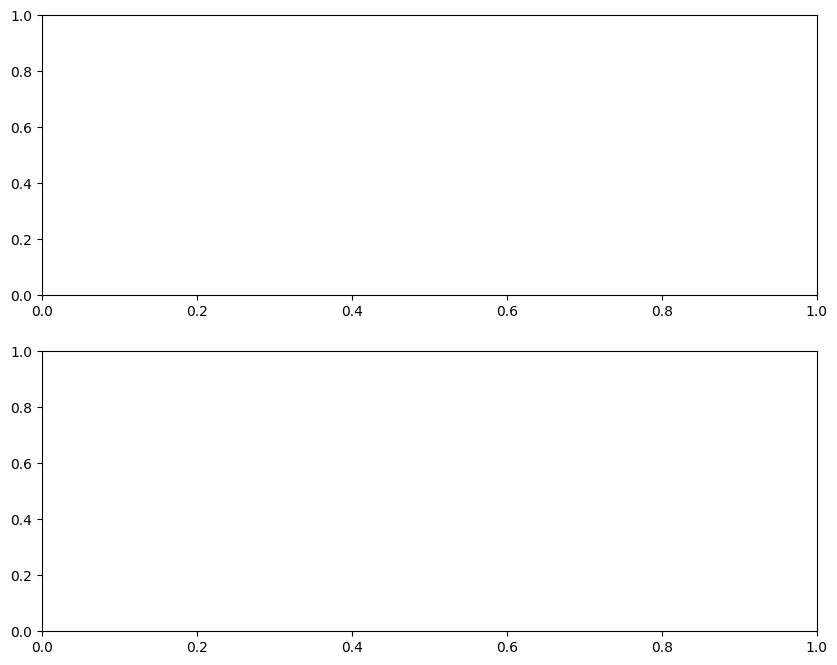

In [69]:
%%time
params = {
    'n': 15,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 0.8,
    'validate_each': 1000000,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(0, 2, params)

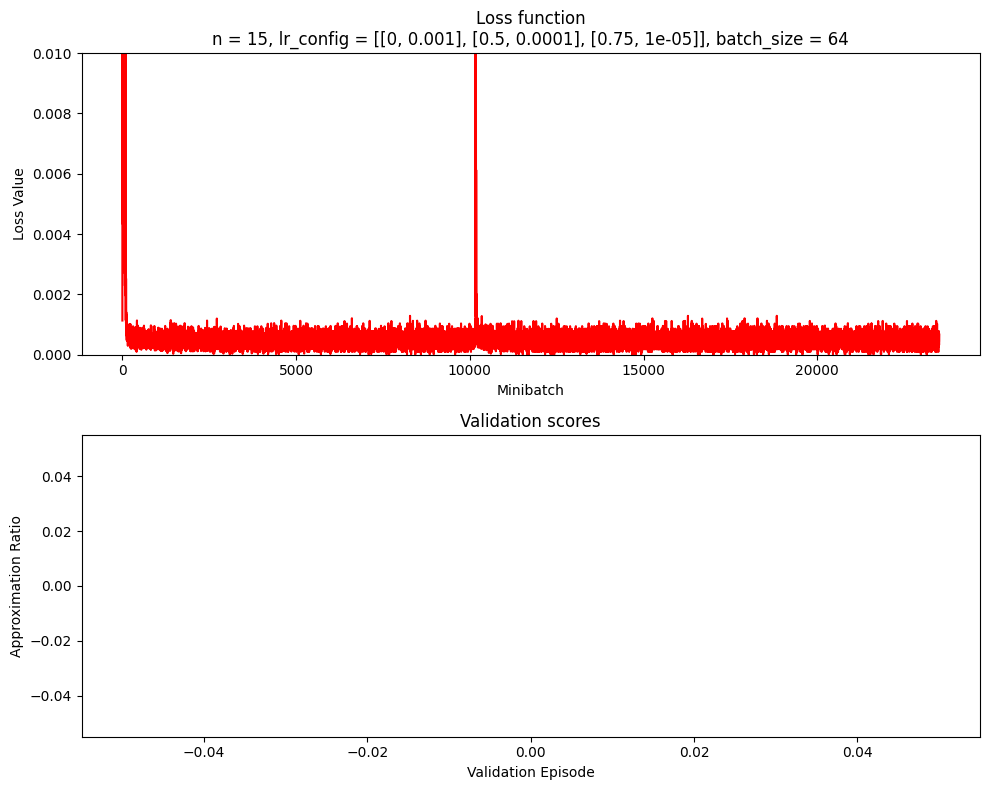

In [70]:
replay_graphs('outputs-mvc/run_0', max_loss=1e-2, filename=None)

{'n': 15, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 0.8, 'validate_each': 1000000, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Starting run #2/2...
CPU times: user 3min 37s, sys: 49.9 s, total: 4min 27s
Wall time: 4min 17s


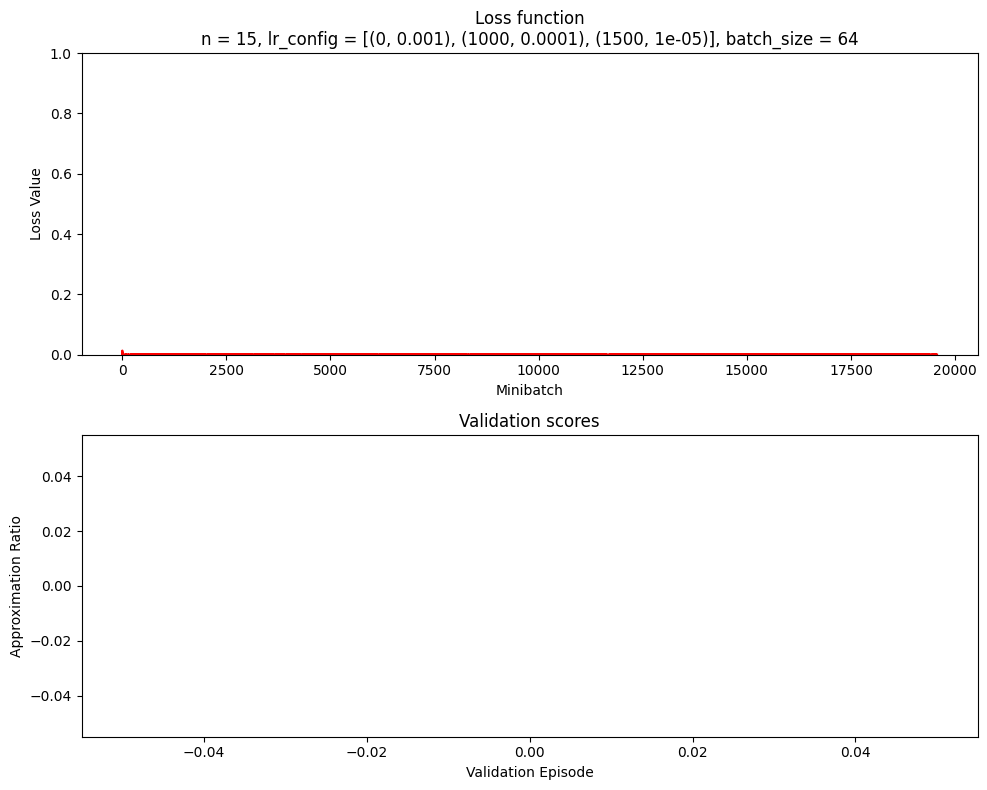

In [74]:
%%time
params = {
    'n': 15,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 0.8,
    'validate_each': 1000000,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(1, 2, params)

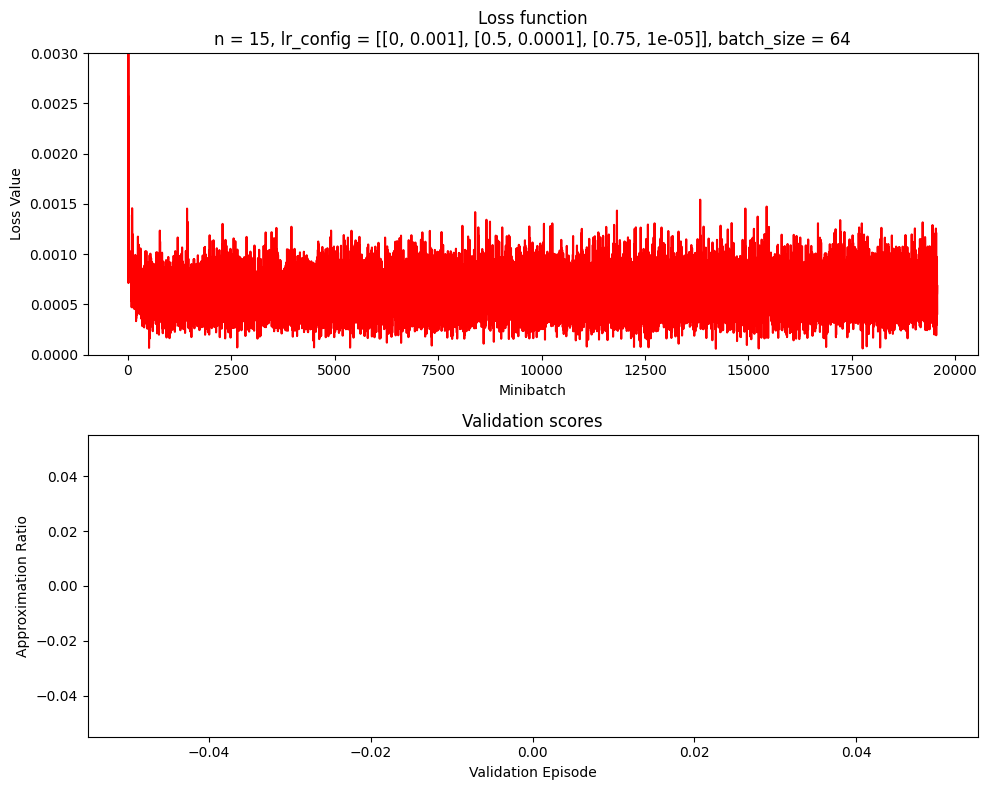

In [87]:
replay_graphs('outputs-mvc/run_1', max_loss=3e-3, filename=None)

In [26]:
n = 15
env = MVCEnv(n, n, graph_type=MVCEnv.BARABASI_ALBERT)
agent = Agent(
    nstep=1,
    normalize=True,
    batch_size=16,
    lr=1e-4, # LR is set via LR scheduler 
    n_node_features=1,
    n_edge_features=0
)

eps_start = 1.0
eps_end = 0.01
eps_end_at_episode = 0.9
eps_decay = (eps_end / eps_start) ** (1 / (n * eps_end_at_episode))
scores, val_scores = train(agent, env, eps_start, eps_decay,
                           eps_end, n_episodes=1000, validate_each=100000, validate_at_start=False)

[100/1000] loss: 1.209e-04, q_target: -7.548e-02, q_expected: -9.178e-02, eps: 0.0100, time: 3.33s
    θ1: -1.526e-01, θ2: -6.781e-02, θ3: 9.410e-03, θ5: 8.239e-02, θ6: 3.055e-02, θ7: -4.003e-02
[200/1000] loss: 3.744e-04, q_target: -7.401e-02, q_expected: -7.786e-02, eps: 0.0100, time: 6.48s
    θ1: -1.599e-01, θ2: -6.797e-02, θ3: 9.410e-03, θ5: 8.238e-02, θ6: 3.055e-02, θ7: -4.084e-02
[300/1000] loss: 1.068e-03, q_target: -7.455e-02, q_expected: -8.647e-02, eps: 0.0100, time: 9.93s
    θ1: -1.627e-01, θ2: -6.814e-02, θ3: 9.410e-03, θ5: 8.237e-02, θ6: 3.055e-02, θ7: -4.171e-02
[400/1000] loss: 3.568e-04, q_target: -7.481e-02, q_expected: -8.155e-02, eps: 0.0100, time: 13.19s
    θ1: -1.652e-01, θ2: -6.829e-02, θ3: 9.410e-03, θ5: 8.235e-02, θ6: 3.055e-02, θ7: -4.284e-02
[500/1000] loss: 2.072e-05, q_target: -7.501e-02, q_expected: -8.246e-02, eps: 0.0100, time: 16.56s
    θ1: -1.661e-01, θ2: -6.836e-02, θ3: 9.410e-03, θ5: 8.232e-02, θ6: 3.056e-02, θ7: -4.375e-02
[600/1000] loss: 3.639e

In [27]:
len(scores)

1000

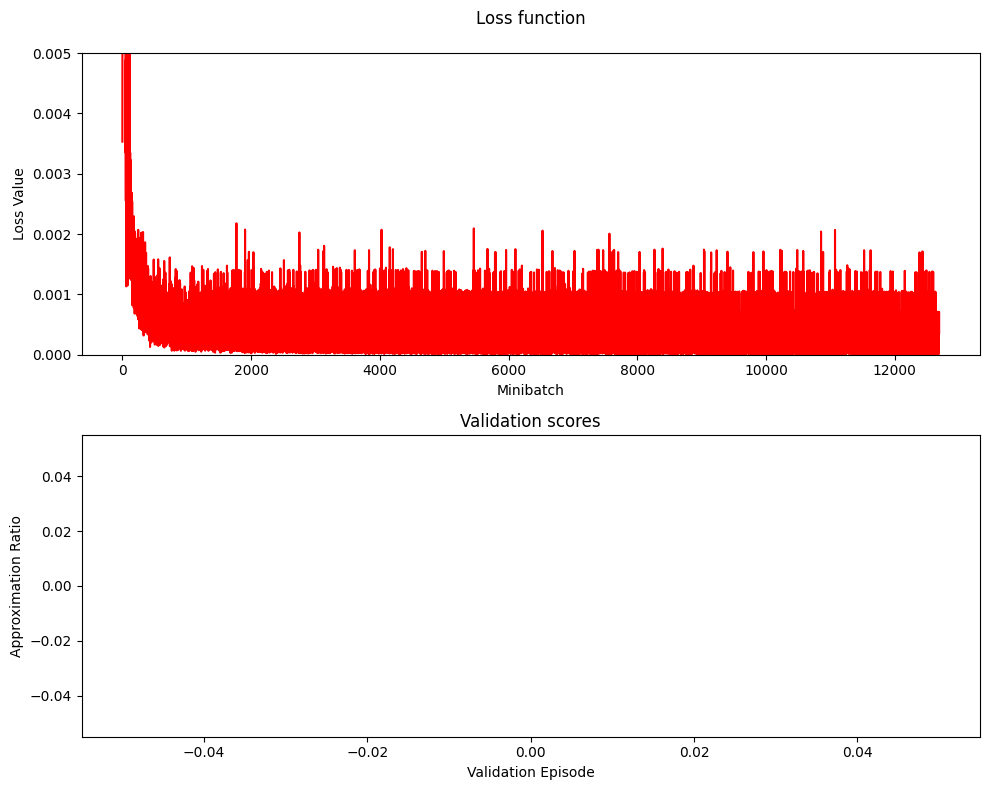

In [30]:
plot_graphs(agent.losses, [], max_loss=0.005)